#**Beijing Air Quality Forecasting Starter Notebook**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Data Preperation**



## **Load and preprocess data**

In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv',
                    header=0, skiprows=[1])
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv',
                   header=0, skiprows=[1])

## **Explore the training data**

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
1,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
2,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
3,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN
4,6,-1.442309,-1.840273,0.053790,-0.155751,-0.069353,-0.137667,2010-01-01 05:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [6]:
# Convert 'datetime' to datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
train.set_index('datetime', inplace=True)
test['datetime'] = pd.to_datetime(test['datetime'])
test.set_index('datetime', inplace=True)

In [7]:
# Extract time features
for df in [train, test]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)

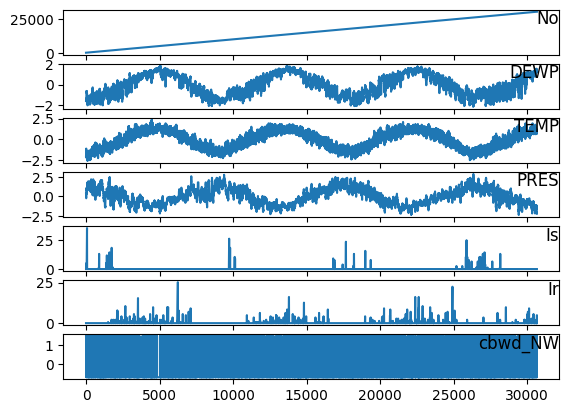

In [8]:
values = train.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(train.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [ ]:
# Ensure 'datetime' column is in datetime format
# train['datetime'] = pd.to_datetime(train['datetime'])

# test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
# train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
# test.set_index('datetime', inplace=True)

##**Handle missing values**
Check the dataset for missing values and decide how to handle them.
In this example, missing values are filled with the mean. You can experiment with other strategies.

In [9]:
# Handle missing values using training data's mean
train_mean = train.mean()
train.fillna(train_mean, inplace=True)
test.fillna(train_mean, inplace=True)

##**Separate features and target**
Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [36]:
# Create a DataFrame for supervised conversion that retains 'pm2.5'
data_for_supervised = train.drop('No', axis=1)

# Prepare separate X and y for reference (X will be used for feature scaling later)
X = data_for_supervised.drop('pm2.5', axis=1)
y = data_for_supervised['pm2.5']
# For test, drop 'No'
X_test = test.drop(['No'], axis=1)

In [34]:
print("X shape:", X.shape)
print("n_features (from X):", X.shape[1])


X shape: (30675, 15)
n_features (from X): 15



## **Convert Series to Supervised Learning Format**


In [37]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    """
    n_vars = data.shape[1]
    df = data.copy()
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{col}(t-{i})' for col in df.columns]
    # Forecast sequence (t, t+1, ... t+n_out-1)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{col}(t)' for col in df.columns]
        else:
            names += [f'{col}(t+{i})' for col in df.columns]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [19]:
# We choose a window of 3 hours and predict one step ahead.
n_hours = 3
n_out   = 1

In [20]:
# Create supervised learning dataset using all features (including target)
supervised = series_to_supervised(data_for_supervised, n_in=n_hours, n_out=n_out)

In [56]:
# The target will be the 'pm2.5(t)' column.
n_features = X.shape[1]
n_obs = n_hours * n_features

## **Split Supervised Data into Training and Validation Sets**

In [40]:
# Convert supervised DataFrame to NumPy array
values = supervised.values
# Split the supervised data into training and validation sets (70/30 split)
n_train = int(len(values) * 0.7)
train_values = values[:n_train, :]
val_values   = values[n_train:, :]

In [57]:
# Target extraction: Get the 'pm2.5(t)' column from the last block.
target_col_index = list(data_for_supervised.columns).index('pm2.5')
train_X = train_values[:, :n_obs]
train_y = train_values[:, n_obs + target_col_index]
val_X   = val_values[:, :n_obs]
val_y   = val_values[:, n_obs + target_col_index]

In [58]:
# Reshape inputs to 3D: [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X   = val_X.reshape((val_X.shape[0], n_hours, n_features))

## **Scaling**

In [59]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
# Flatten 3D arrays to 2D for scaling, then reshape back
train_X_flat = train_X.reshape((train_X.shape[0], n_obs))
val_X_flat   = val_X.reshape((val_X.shape[0], n_obs))
scaler_X = scaler_X.fit(train_X_flat)
train_X_scaled = scaler_X.transform(train_X_flat).reshape(train_X.shape)
val_X_scaled   = scaler_X.transform(val_X_flat).reshape(val_X.shape)

scaler_y = MinMaxScaler(feature_range=(0, 1))
train_y = train_y.reshape(-1, 1)
val_y = val_y.reshape(-1, 1)
scaler_y = scaler_y.fit(train_y)
train_y_scaled = scaler_y.transform(train_y)
val_y_scaled   = scaler_y.transform(val_y)

## **Build the LSTM Model (Simple Architecture)**

In [60]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X_scaled.shape[1], train_X_scaled.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          13,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,251 (51.76 KB)

 Trainable params: 13,251 (51.76 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(train_X_scaled, train_y_scaled,
                    epochs=50,
                    batch_size=72,
                    validation_data=(val_X_scaled, val_y_scaled),
                    verbose=2,
                    shuffle=False)

Epoch 1/50
299/299 - 3s - 11ms/step - loss: 0.2660 - val_loss: 0.1876
Epoch 2/50
299/299 - 1s - 4ms/step - loss: 0.1809 - val_loss: 0.1699
Epoch 3/50
299/299 - 1s - 4ms/step - loss: 0.1648 - val_loss: 0.1598
Epoch 4/50
299/299 - 1s - 4ms/step - loss: 0.1578 - val_loss: 0.1521
Epoch 5/50
299/299 - 3s - 11ms/step - loss: 0.1534 - val_loss: 0.1551
Epoch 6/50
299/299 - 2s - 8ms/step - loss: 0.1516 - val_loss: 0.1508
Epoch 7/50
299/299 - 2s - 5ms/step - loss: 0.1491 - val_loss: 0.1524
Epoch 8/50
299/299 - 3s - 8ms/step - loss: 0.1499 - val_loss: 0.1526
Epoch 9/50
299/299 - 2s - 8ms/step - loss: 0.1484 - val_loss: 0.1491
Epoch 10/50
299/299 - 1s - 5ms/step - loss: 0.1475 - val_loss: 0.1488
Epoch 11/50
299/299 - 3s - 9ms/step - loss: 0.1438 - val_loss: 0.1440
Epoch 12/50
299/299 - 3s - 10ms/step - loss: 0.1435 - val_loss: 0.1462
Epoch 13/50
299/299 - 2s - 6ms/step - loss: 0.1438 - val_loss: 0.1463
Epoch 14/50
299/299 - 1s - 4ms/step - loss: 0.1434 - val_loss: 0.1434
Epoch 15/50
299/299 - 2s -

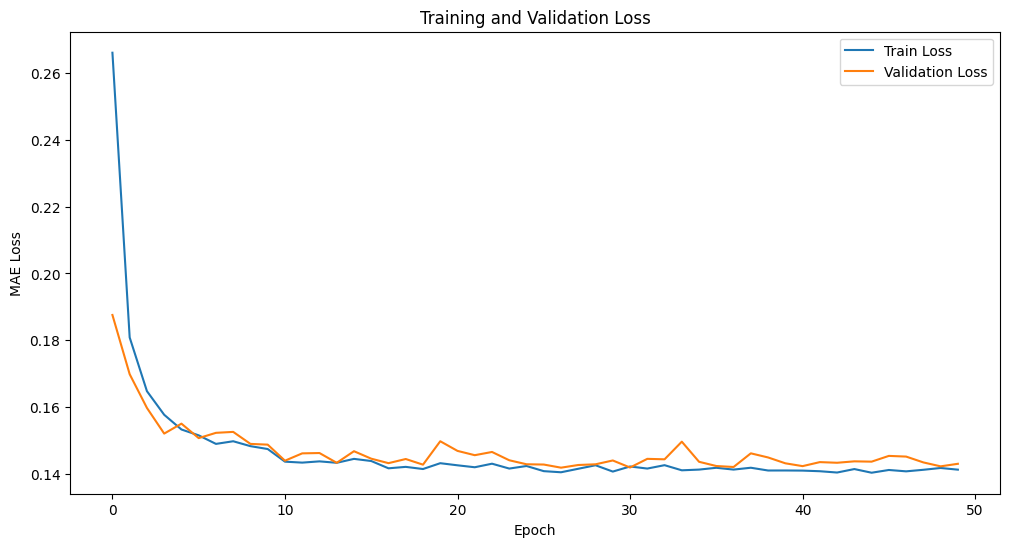

In [62]:
# Plot training history
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

In [63]:
# Evaluate performance using RMSE on the validation set
yhat = model.predict(val_X_scaled)
inv_yhat = scaler_y.inverse_transform(yhat)
inv_y = scaler_y.inverse_transform(val_y_scaled)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Validation RMSE: %.3f' % rmse)

288/288 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation RMSE: 0.791


##**Prepare Test Set Predictions for Submission**

In [65]:
def create_supervised_test(X, window_size):
    """Create test sequences using a sliding window from the test DataFrame."""
    Xs = []
    for i in range(window_size, len(X) + 1):
        Xs.append(X.iloc[i - window_size:i].values)
    return np.array(Xs)

In [66]:
# Create test sequences from X_test (which has the same features as X)
X_test_seq = create_supervised_test(X_test, n_hours)
print("X_test_seq shape:", X_test_seq.shape)

X_test_seq shape: (13145, 3, 15)


##**Scale test sequences**

In [67]:
test_seq_shape = X_test_seq.shape
# Flatten each sample to (n_hours * n_features) elements; expected: 3 * 15 = 45.
X_test_seq_flat = X_test_seq.reshape((test_seq_shape[0], n_hours * n_features))
# Transform using scaler_X and reshape back to 3D.
X_test_scaled_seq = scaler_X.transform(X_test_seq_flat).reshape((test_seq_shape[0], n_hours, n_features))

In [68]:
# Predict on the test sequences
predictions_scaled = model.predict(X_test_scaled_seq)
predictions = scaler_y.inverse_transform(predictions_scaled)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


##**Create and Save the Submission File**

In [69]:
# Our sliding window produced predictions for indices starting at test.index[n_hours - 1].
# This yields len(test) - (n_hours - 1) predictions.
print("Number of predictions before padding:", len(predictions))
print("Test set length (from index):", len(test.index))


Number of predictions before padding: 13145
Test set length (from index): 13147


In [70]:
# Kaggle expects exactly 13,148 rows.
expected_rows = 13148
missing_count = expected_rows - len(predictions)
if missing_count > 0:
    # Pad at the beginning with the first predicted value.
    pad = np.full((missing_count,), predictions[0])
    full_predictions = np.concatenate([pad, predictions.flatten()])
else:
    full_predictions = predictions.flatten()

print("Total predictions after padding:", len(full_predictions))

Total predictions after padding: 13148


In [75]:
# The test predictions correspond to test timestamps starting at test.index[n_hours - 1]
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index[n_hours - 1:]).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': np.round(predictions.flatten()).astype(int)
})

submission = submission.sort_values('row ID')

# Save submission file
save_path = "/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/"
os.makedirs(save_path, exist_ok=True)
submission.to_csv(save_path + "subm18_fixed.csv", index=False)
print("Submission file formatted and saved!")

Submission file formatted and saved!


# **Second starts here**

In [12]:
# Split into train and validation (NO SHUFFLING)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
# Scale data using training statistics
scaler_X = MinMaxScaler().fit(X_train)
scaler_y = MinMaxScaler().fit(y_train.values.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

# Reshape for LSTM (samples, timesteps, features)
def reshape_data(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

X_train_reshaped = reshape_data(X_train_scaled)
X_val_reshaped = reshape_data(X_val_scaled)
X_test_reshaped = reshape_data(X_test_scaled)

In [ ]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
# X_train = np.expand_dims(X_train, axis=1)

##**Build model**
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [24]:
# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_reshaped, y_train_scaled,
    validation_data=(X_val_reshaped, y_val_scaled),
    epochs=50,
    batch_size=72,
    # callbacks=[early_stopping, reduce_lr],
    verbose=2,
    shuffle=False
)

Epoch 1/50
341/341 - 4s - 11ms/step - loss: 0.0064 - mae: 0.0584 - val_loss: 0.0214 - val_mae: 0.1045
Epoch 2/50
341/341 - 1s - 4ms/step - loss: 0.0063 - mae: 0.0580 - val_loss: 0.0258 - val_mae: 0.1192
Epoch 3/50
341/341 - 1s - 3ms/step - loss: 0.0064 - mae: 0.0587 - val_loss: 0.0254 - val_mae: 0.1187
Epoch 4/50
341/341 - 1s - 4ms/step - loss: 0.0064 - mae: 0.0584 - val_loss: 0.0240 - val_mae: 0.1150
Epoch 5/50
341/341 - 2s - 5ms/step - loss: 0.0063 - mae: 0.0573 - val_loss: 0.0219 - val_mae: 0.1086
Epoch 6/50
341/341 - 3s - 8ms/step - loss: 0.0061 - mae: 0.0560 - val_loss: 0.0200 - val_mae: 0.1021
Epoch 7/50
341/341 - 2s - 6ms/step - loss: 0.0060 - mae: 0.0550 - val_loss: 0.0185 - val_mae: 0.0969
Epoch 8/50
341/341 - 1s - 4ms/step - loss: 0.0059 - mae: 0.0544 - val_loss: 0.0174 - val_mae: 0.0930
Epoch 9/50
341/341 - 1s - 3ms/step - loss: 0.0058 - mae: 0.0540 - val_loss: 0.0167 - val_mae: 0.0903
Epoch 10/50
341/341 - 1s - 4ms/step - loss: 0.0057 - mae: 0.0537 - val_loss: 0.0161 - val_

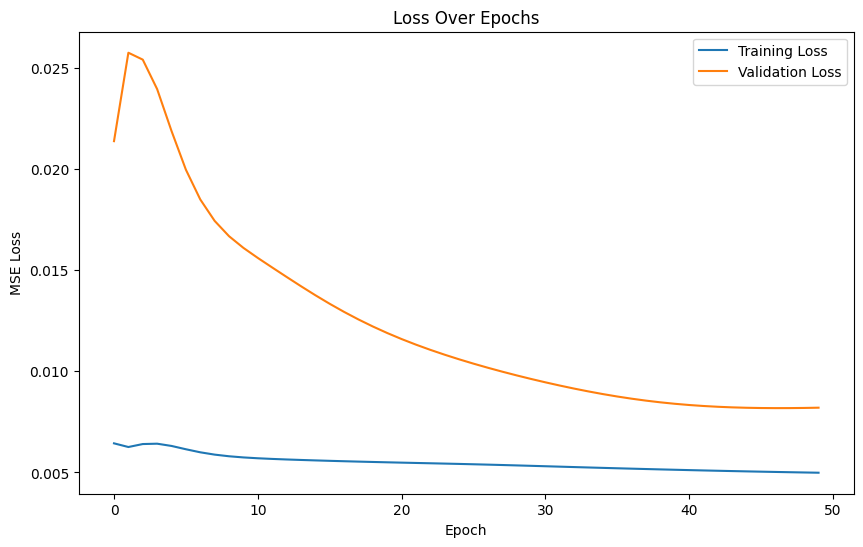

In [26]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [23]:
# Predict on the test data
predictions = model.predict(X_test_reshaped)

# Reshape predictions to 2D before inverse transforming
predictions = predictions.reshape(-1, 1)

# Inverse transform predictions to original scale
predictions = scaler_y.inverse_transform(predictions)

# Prepare submission with proper formatting
submission = pd.DataFrame({
    'row ID': test.index.strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort by row ID to ensure chronological order
submission = submission.sort_values('row ID')

# Save submission
save_path = "/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/"
submission.to_csv(save_path + "subm17_fixed.csv", index=False)
print("Submission file formatted and saved!")

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Submission file formatted and saved!
